# Applying a neural network to the Fashion MNIST dataset

Using a grayscale image of a clothing article, how can we classify the type of clothing article? E.g shirt, pants, etc...

## Import Dependencies
PyTorch, or torch, is the python deep learning library we use for our neural networks. 

Torchvision is an extension of this tool for computer vision specific functions such as transforming images and image datasets. 

torch.nn is the neural network specific part of the torch library and torch.nn.functional has the activation functions we want to use (such as ReLU). 

In [1]:
%pip install torch torchvision
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

Note: you may need to restart the kernel to use updated packages.


## Configure cuda/gpu if available

GPU boost training time. Why? Because it lets us do hundreds to thousands of calculations at the same time

CUDA is the API that we will use for GPU training. If CUDA is available we want to use it, and otherwise use the CPU. If you are using Google colab, it comes with a built in GPU for use so make sure to activate it by going to Runtime->Change runtime type->GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h1>Preprocessing our Images</h1>

The transform that we will perform on our dataset is first converting all images to tensors. Tensors are the built in array datatype in pytorch, like numpy arrays. If you are interested, learn about why they are useful in keeping track of gradients here:
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html .

Converting to a tensor also converts an image with pixel values from 0 to 255 to a matrix with numbers from 0 to 1. 

In addition, we are normalizing the data to a range between -1 and 1. If the range before is [0,1], subtracting 0.5 will give us [-0.5,0.5] and dividing by 0.5 will make the range wider to [-1,1]. torch.Normalize subtracts the first parameter from all the values in the image and divides by the second parameter. 

transforms docs - https://pytorch.org/vision/stable/transforms.html



In [3]:
# Convert Data to Tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

## Hyperparameters

datasets docs - https://pytorch.org/vision/stable/datasets.html

The input size is the number of pixels in each images, which is 28 by 28.

The number of classifcation (num_classes) is 10 because there are 10 possible classifications the model can make, such as T-shirt/top, trouser, bag, etc... 

The number of epochs is how many times the training iterates over the dataset. For example, num_epochs of 8 means that the model will iterate over the dataset 10 times and each image is classified 10 times in training. More epochs means more training. If the loss is still going down after the last epoch, you should be training for more epochs. 

A batch size of 8 means 8 images at a time are passed into the model. A larger batch size means more images are passed at a time and there is faster training. Also, training is less variable, meaning it goes in a consistent image (think of it as using the average of the 8 images) while a batch size of 1 changes the weights for every image leading to more variable training. 

In [4]:
# hyperparameters
input_size = 28 * 28 # 28 * 28 images
num_classes = 10 # 10 possible classifications/outputs for the model
num_epochs = 10 # 10 iterations over the dataset
batch_size = 8 # 8 images passed at a time into the model

#the names of all the possible classifications
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

# Applying the transforms

We are using the datasets.FashionMNIST function from torchvision to import the dataset. 

### Parameters to the function:

The root parameter sets the directory that we import the data to (and create it if it doesn't exist.)

The train parameter determines if we are importing training or testing fashion MNIST dataset. 

The transform parameter determines the transforms we apply during preprocessing, which were defined above.

download=True gives the function permission to download the data into the directory if it doesn't exist there. 

In [5]:
# training set
train_dataset = torchvision.datasets.FashionMNIST(
    root = "./data",
    train = True,
    transform = transform,
    download = True
)

# EXERCISE: do the same thing for the testing dataset and call it test_dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root = "./data",
    train = False,
    transform = transform,
    download = True
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Dataloaders

The pytorch dataloader function creates an iterator that will give us one batch at a time as we iterate over the dataset. The parameters are self-explanatory, but the shuffle parameter shuffles the dataset. This is useful because we want to sample randomly and not go through all the data points from each classification one at a time. We wouldn't know the order of real world data. 

In [6]:
# Get batched Dataloaders
trainloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True # optional
)

#EXERCISE: Create a dataloader for the testing dataset called testloader
testloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = True
)

## Visualize our data

matplotlib docs - https://matplotlib.org/stable/users/index

We first create a wrapper class for the pyplot imshow method, which is used to show RGB images on the screen. We first perform the opposite transformations as our initial normalization, to put the range of the pixels back between 0-1 (needed for pyplot. Next, we turn the tensor image into a numpy array and transpose the dimensions of image. 

Why do we need to transpose the color channels? Because the tensor image is (28,28,3) so 28 by 28 which each unit having a third dimension of (R,G,B). We want it (3,28,28) so 3 distinct color channels with each channel being a different matrix (3 matrices). Finally, actually show the new image with plt.show(). 

Then we turn the train dataloader into an iterator and call the next() function to get the next batch of images and labels for display. Using the handy torch.utils.make_grid function, we can turn the images in the batch into one single row image, and at the end print out the classification/label for each image

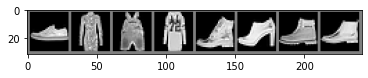

Sneaker Dress Trouser Dress Ankle boot Ankle boot Ankle boot Ankle boot


In [14]:
import matplotlib.pyplot as plt
import numpy as np

#imshow wrapper function to display image
def imshow(img):
    img = img*0.5 +0.5
    # EXERCISE: reverse normalization transform. Go up and see which operations were performed and do the opposite
    npimg = img.numpy() #turn the image tensor into a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #transpose the array to  3x28x28 instead of 28x28x3
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #get the next batch of images from the iterator dataloader

# show images
imshow(torchvision.utils.make_grid(images)) #turn the batch of images into one image grid
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))) #print out all the classifications for each image

##### H2 = size of height after convolution
##### W2 = size of width after convolution
##### H1 = primitive height size
##### FH = filter's height size
##### W1 = primitive width size
##### WH = filter's width size
##### P = num padding
##### S = stride

##### H2 = (H1 - FH + 2P)/S + 1
##### W2 = (W1 - FW + 2P)/S + 1

<h1>Creating Our Model</h1>

Data format: [batch_size, 1(grey) (3 if RGB but not applicable here), 28, 28]

Module docs - https://pytorch.org/docs/stable/generated/torch.nn.Module.html <br> nn docs - https://pytorch.org/docs/stable/nn.html

## Convolutional Neural Network

First we create two main groups at the beginning, the first convolutional group and the second convolutional group. Each convolutional group has a convolutional layer, an activation function (RELU) and a pooling layer. 

Remember, the convolutional layer passes multiple filters over each channel and can change the number of channels. Into the convolutional layer we pass in the number of input channels and the number of output channels. The kernel size is the size of our filter (e.g 5x5 filter) and the stride is how many pixels to the right we move everytime we apply a filter. Finally, the padding determines how many layers of zeroes we add to the border. 

The second convolutional group (the one you have the code) is only different in the number of input and output channels of the convolutional layer. Create a convolutional layer with 16 input channels (output of the previous group) and 32 output channels. 



In [15]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__() 
    self.conv_layer_1 = nn.Sequential( # input.shape: [batch, 1, 28, 28]
        nn.Conv2d(
            in_channels=1, # grey scale, 3 otherwise if RGB   
            out_channels=16, # 16 x 1(grey scale, 3 otherwise if RGB ) filters
            kernel_size=5, # convolution extraction size
            stride=1,
            padding=2 # for convoluted output to be same size,
                      # need padding=(kernel_size-1)/2 if stride = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # (2x2 maxpool), out.shape: [16, 14, 14]
    )
    #EXERCISE: Code second convolutional group
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.fc = nn.Linear(32*7*7, 10)

  def forward(self, x):
    # x.shape: [batch_size, 1, 28, 28] -> [batch_size, 16, 14, 14]
    x = self.conv_layer_1(x)
    # x.shape: [batch_size, 16, 14, 14] -> [batch_size, 32, 7, 7]
    x = self.conv_layer_2(x)
    x = x.view(x.shape[0], -1) # flatten: [batch_size, 32*7*7]
    # x.shape: [batch_size, 32*7*7] -> [batch_size, 10]
    out = self.fc(x)
    return out

optim docs - https://pytorch.org/docs/stable/optim.html

## Initializing the model, loss, and optimizer. 

First we initialize the model (our CNN). Next we transfer the CNN's weights over to the GPU. 

Afterward we initialize the cross entropy loss function, which is a loss function used for multi-class problems. Cross entropy heavily penalizes predictions that are far away from the true class distribution. 

In [18]:
model = CNN()
model.to(device) # cast model to device

criterion = nn.CrossEntropyLoss()
#EXERCISE: transfer the loss function over to the GPU. 
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training our Model

The training process goes somewhat like this
go through the dataset [epoch] times<br>
&ensp;  go through each image in the dataset<br>
&ensp;&ensp; transfer inputs and labels to GPU<br>
&ensp;&ensp; get prediction for input<br>
&ensp;&ensp; check if prediction matches label, get loss<br>
&ensp;&ensp; see which direction you have to change the weights<br>
&ensp;&ensp; actually change weights using optimizer and learning rate
&ensp;&ensp; Set the directions back to zero (optim.zero_grad())<br>
&ensp;&ensp; add loss to total loss until reset<br>
&ensp;&ensp; after some iterations, print out loss and reset

In [25]:
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device) # put input image onto gpu
        labels = labels.to(device) # put label onto gpu

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #EXERCISE: Calculate "loss" by passing the outputs and labels into the loss function
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 3750 == 3749:    # print every 3750 mini-batches
            #EXERCISE: print and reset total loss
            print(loss)
            running_loss==0
print('Finished Training')

tensor(0.3681, grad_fn=<NllLossBackward0>)


tensor(0.3799, grad_fn=<NllLossBackward0>)


tensor(0.0550, grad_fn=<NllLossBackward0>)


tensor(0.2051, grad_fn=<NllLossBackward0>)


tensor(0.0918, grad_fn=<NllLossBackward0>)


tensor(0.1319, grad_fn=<NllLossBackward0>)
Finished Training


<h1>Evaluating our Model</h1>

In [0]:
#EXERCISE: turn the test dataloader (called testloader) into an iterator and get the next image batch

# print images
#EXERCISE: Display the batch using torch.util.make_grid
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Evaluation Loop
Turn off gradient descent using torch.no_grad. <br>
&ensp; Iterate through every batch in the dataset<br>
&ensp; Get the prediction of every image in the batch<br>
&ensp; Add the number of images to the total<br>
&ensp; Add the number of correctly classified images to a counter<br>
&ensp; Get the accuracy through correct/total.<br>


In [0]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        #EXERCISE: Split the data into image and labels as done in the training loop
        #EXERCISE: Transfer the inputs and labels to the GPU
        #EXERCISE: calculate outputs by running images through the network
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

<h1>Using our Model</h1>

Here we simply pick a random image from our dataset and apply the model to it. 

In [0]:
import random
rand = random.randint(0,9999)
image = test_dataset[rand][0] # shape: [(1) batch_size, 28, 28]
plt.subplot()
plt.axis('off')
# [1, 28, 28] -> [28, 28]
plt.imshow(image.squeeze(0))
print(f"Ground Truth: {classes[test_dataset[rand][1]]}")

In [0]:
with torch.no_grad():
    # cast input to device
    # [(1), 28, 28] -> [(1), (1), 28, 28]
    image = image.to(device)

    log_preds = model(image.unsqueeze(0))

# post processes the image into more usable numbers
#   Math: probabilites were natural logged, so torch.exp() performs e^(log_preds)
preds = torch.exp(log_preds)
probab = list(preds.cpu().numpy()[0])
pred_label = probab.index(max(probab)) # get index of max num (highest probability)

print(f"Prediction: {classes[pred_label]}")